In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [3]:
import sys
import os

In [4]:
sys.path.append(os.path.abspath('../scripts'))

In [5]:
from analysis_and_modeling import *

In [5]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-10-31'

In [6]:
data = fetch_data(tickers, start_date, end_date)

[*********************100%***********************]  3 of 3 completed


In [7]:
cleaned_data, missing_values = sanitize_data(data)
print("Missing Values:\n", missing_values)

Missing Values:
 Ticker
BND     0
SPY     0
TSLA    0
dtype: int64


c:\Users\Abdulaziz\Desktop\10 Academy\GMF\scripts\analysis_and_modeling.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.interpolate(method='linear').fillna(method='bfill')
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\scripts\analysis_and_modeling.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame = data_frame.fillna(method='bfill').fillna(method='ffill')


In [8]:
summary_stats = summarize_data(cleaned_data)
summary_stats

Ticker,BND,SPY,TSLA
count,2474.000000,2474.000000,2474.000000
mean,70.089252,310.253153,111.438965
std,4.889919,111.250656,110.120450
min,62.637600,157.328568,9.578000
25%,66.314068,214.822342,17.066167
50%,68.888935,275.812332,25.043000
75%,73.807495,402.297508,216.865002
max,79.812935,584.590027,409.970001


In [9]:
normalized_data = standardize_data(cleaned_data)

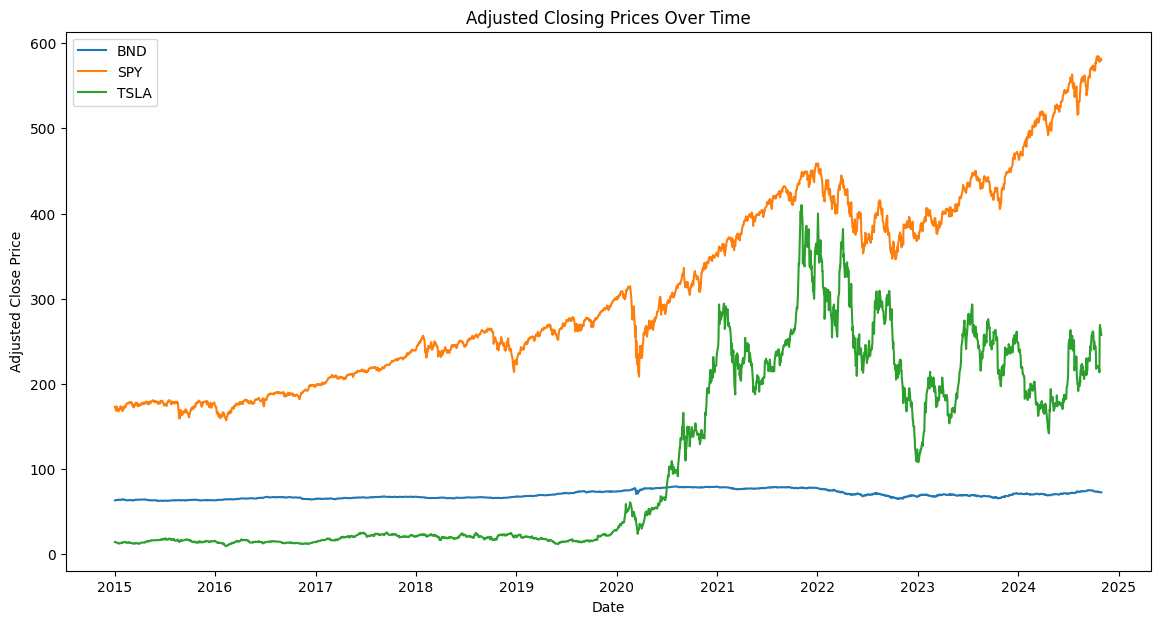

In [10]:
visualize_closing_prices(cleaned_data)

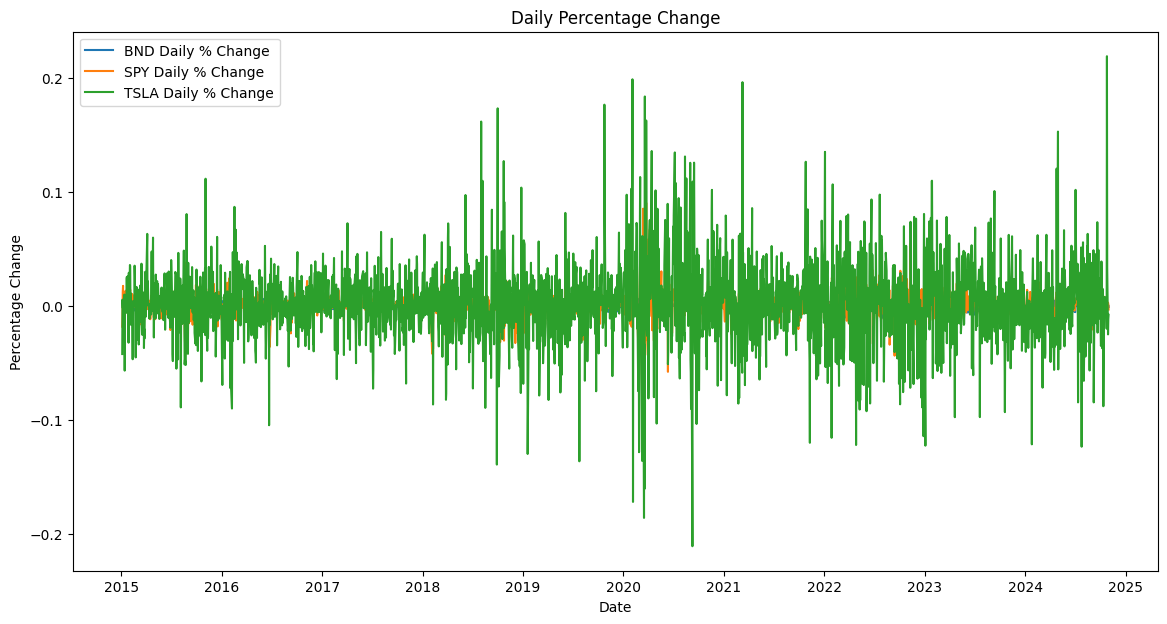

In [11]:
pct_change = visualize_daily_percentage_change(cleaned_data)

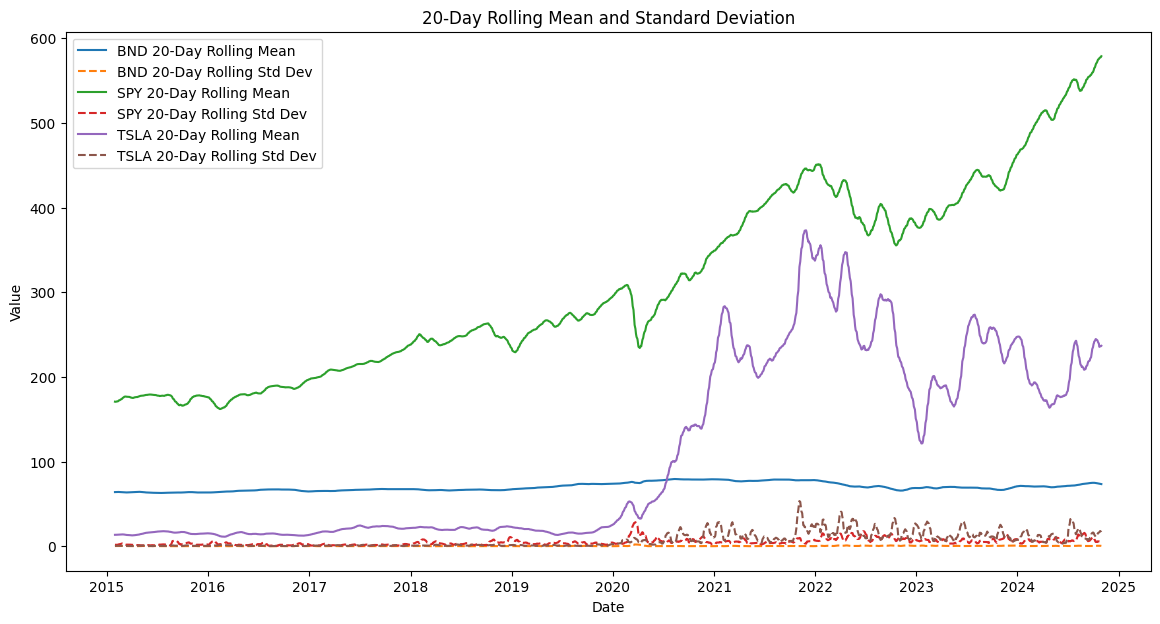

In [12]:
visualize_rolling_statistics(cleaned_data, window_size=20)

In [13]:
outliers = identify_outliers(pct_change)
outliers

,BND,SPY,TSLA
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
2468,NaN,NaN,0.21919
2469,NaN,NaN,NaN
2470,NaN,NaN,NaN
2471,NaN,NaN,NaN


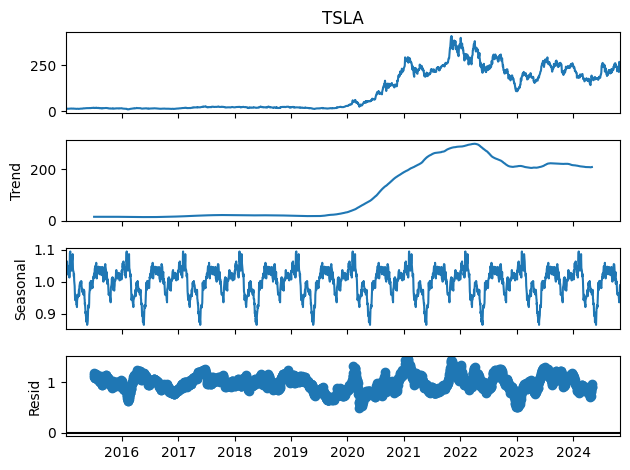

In [14]:
decomposition = decompose_time_series(cleaned_data, 'TSLA')

In [15]:
val_risk, ratio = compute_risk_metrics(cleaned_data)

In [16]:
print(val_risk)
ratio

Ticker
BND    -0.004798
SPY    -0.016764
TSLA   -0.051257
Name: 0.05, dtype: float64


Ticker
BND    -0.004994
SPY     0.042373
TSLA    0.048033
dtype: float64

In [17]:
cleaned_data = cleaned_data.interpolate(method='linear').fillna(method='bfill')

C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_5872\624246787.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_data = cleaned_data.interpolate(method='linear').fillna(method='bfill')


In [18]:
cleaned_data.to_csv('../Data/cleaned_data.csv', index=True)

In [19]:
cleaned_data.head()

Ticker,BND,SPY,TSLA
Date,,,
2015-01-02 00:00:00+00:00,63.358761,173.173798,14.620667
2015-01-05 00:00:00+00:00,63.542736,170.046310,14.006000
2015-01-06 00:00:00+00:00,63.726738,168.444687,14.085333
2015-01-07 00:00:00+00:00,63.765057,170.543625,14.063333
2015-01-08 00:00:00+00:00,63.665409,173.569977,14.041333


In [7]:
data = pd.read_csv('../Data/cleaned_data.csv', parse_dates=['Date'], index_col='Date')

In [8]:
data.head()

,BND,SPY,TSLA
Date,,,
2015-01-02 00:00:00+00:00,63.358761,173.173798,14.620667
2015-01-05 00:00:00+00:00,63.542736,170.046310,14.006000
2015-01-06 00:00:00+00:00,63.726738,168.444687,14.085333
2015-01-07 00:00:00+00:00,63.765057,170.543625,14.063333
2015-01-08 00:00:00+00:00,63.665409,173.569977,14.041333


In [9]:
tsla_data = data['TSLA']
bnd_data = data['BND']
spy_data = data['SPY']

In [10]:
tsla_data_diff = tsla_data.diff().dropna()
bnd_data_diff = bnd_data.diff().dropna()
spy_data_diff = spy_data.diff().dropna()

In [11]:
assess_stationarity(tsla_data_diff) 
assess_stationarity(bnd_data_diff)
assess_stationarity(spy_data_diff)

ADF Statistic: -10.088201009165402
p-value: 1.1404778247005846e-17
Critical Values:
 1%: -3.4330273737125445
 5%: -2.8627228377894505
 10%: -2.567399672341618
The series is likely stationary.
ADF Statistic: -9.742506775683319
p-value: 8.422338947522184e-17
Critical Values:
 1%: -3.4330229961087557
 5%: -2.8627209046733073
 10%: -2.5673986431191405
The series is likely stationary.
ADF Statistic: -10.16994949451398
p-value: 7.133120840055442e-18
Critical Values:
 1%: -3.433026277967909
 5%: -2.862722353917318
 10%: -2.56739941472018
The series is likely stationary.


In [12]:
tsla_data_diff.index = pd.to_datetime(tsla_data_diff.index)
bnd_data_diff.index = pd.to_datetime(bnd_data_diff.index)
spy_data_diff.index = pd.to_datetime(spy_data_diff.index)

In [13]:
tsla_data_diff = tsla_data_diff.asfreq('D').fillna(method='ffill')
bnd_data_diff = bnd_data_diff.asfreq('D').fillna(method='ffill')
spy_data_diff = spy_data_diff.asfreq('D').fillna(method='ffill')

C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_6888\1037180378.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tsla_data_diff = tsla_data_diff.asfreq('D').fillna(method='ffill')
C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_6888\1037180378.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  bnd_data_diff = bnd_data_diff.asfreq('D').fillna(method='ffill')
C:\Users\Abdulaziz\AppData\Local\Temp\ipykernel_6888\1037180378.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spy_data_diff = spy_data_diff.asfreq('D').fillna(method='ffill')


In [14]:
train_size = int(len(tsla_data_diff) * 0.8)

In [15]:
train_data_bnd = bnd_data_diff[:train_size]
test_data_bnd = bnd_data_diff[train_size:]

In [16]:
train_data_spy = spy_data_diff[:train_size]
test_data_spy = spy_data_diff[train_size:]

In [17]:
shared_train_dates = tsla_data_diff.sample(frac=0.8, random_state=42).sort_index().index

In [18]:
train_data = tsla_data_diff.loc[shared_train_dates]
test_data = tsla_data_diff.drop(train_data.index)

In [19]:
train_data_bnd = bnd_data_diff.loc[shared_train_dates]
test_data_bnd = bnd_data_diff.drop(train_data.index)

In [20]:
train_data_spy = spy_data_diff.loc[shared_train_dates]
test_data_spy = spy_data_diff.drop(train_data.index)

c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction resul

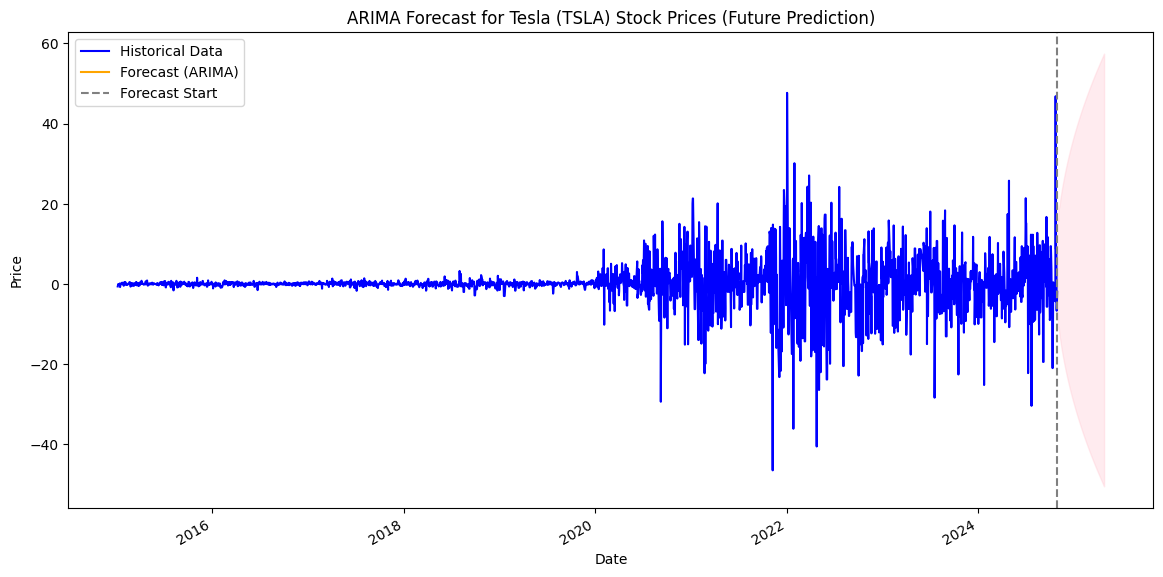

Forecast Summary:
Expected trend over the forecast duration: upward
Confidence intervals show the range of possible price fluctuations.

Volatility and Risk Analysis:
The forecast includes confidence intervals indicating expected price fluctuation ranges.

Market Opportunities and Risks:
Potential market opportunity due to an expected price increase.


In [21]:
arima_tsla = forecast_and_evaluate(train_data, model_choice="arima", asset_label="Tesla (TSLA)")

c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling th

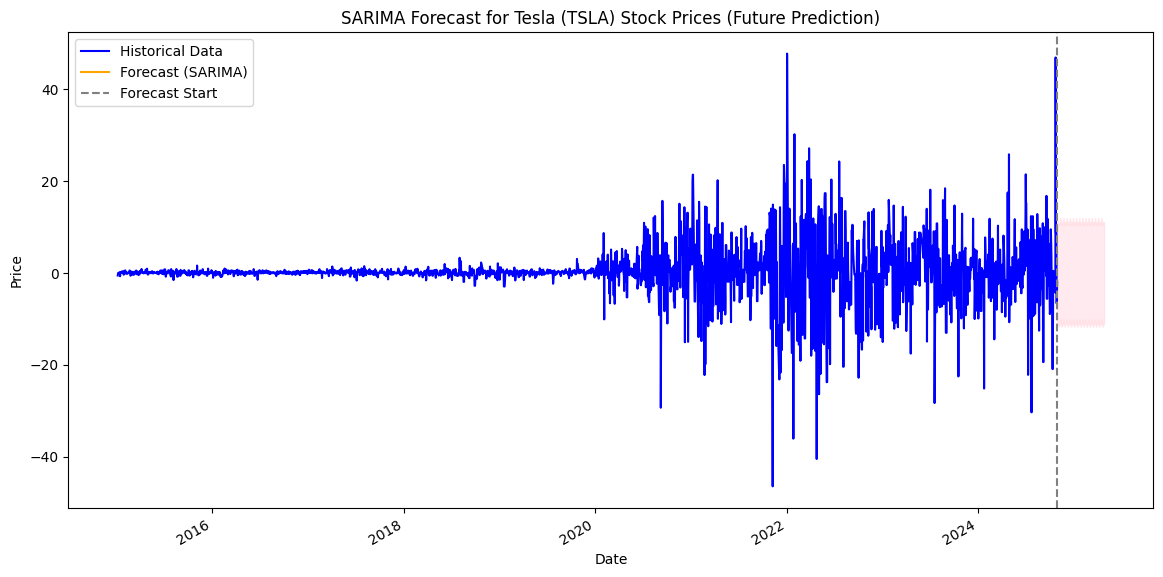

Forecast Summary:
Expected trend over the forecast duration: upward
Confidence intervals show the range of possible price fluctuations.

Volatility and Risk Analysis:
The forecast includes confidence intervals indicating expected price fluctuation ranges.

Market Opportunities and Risks:
Potential market opportunity due to an expected price increase.


In [22]:
sarima_tsla = forecast_and_evaluate(train_data, model_choice="sarima", asset_label="Tesla (TSLA)")

c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 0.0509
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0036
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0034
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0036
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0038
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0038
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0038
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0043
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0038
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0042
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/

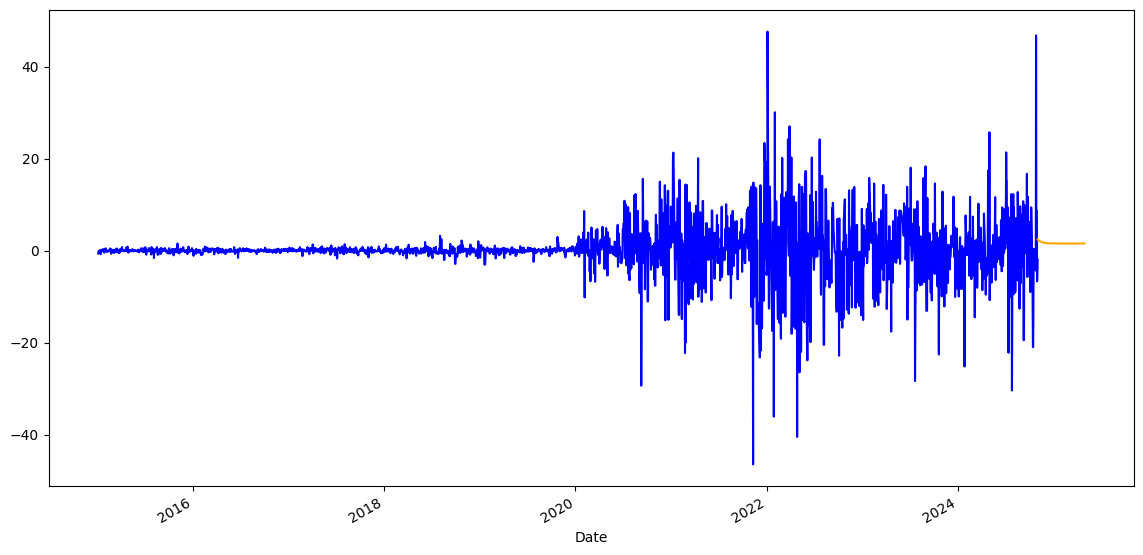

In [23]:
lstm_tsla = forecast_and_evaluate(train_data, model_choice="lstm", asset_label="Tesla (TSLA)")

c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction resul

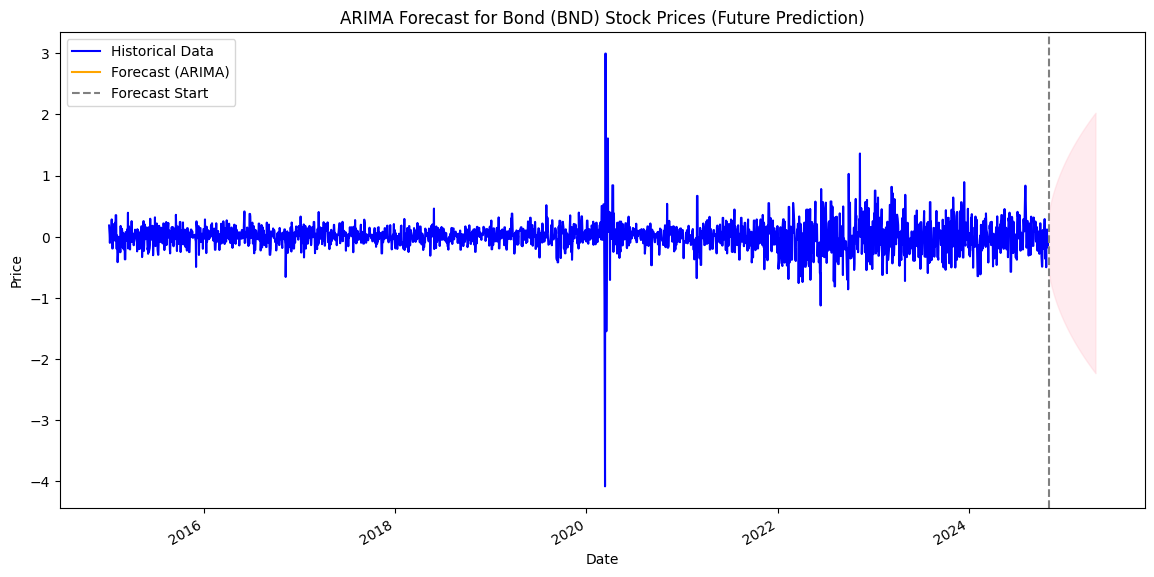

Forecast Summary:
Expected trend over the forecast duration: upward
Confidence intervals show the range of possible price fluctuations.

Volatility and Risk Analysis:
The forecast includes confidence intervals indicating expected price fluctuation ranges.

Market Opportunities and Risks:
Potential market opportunity due to an expected price increase.


c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


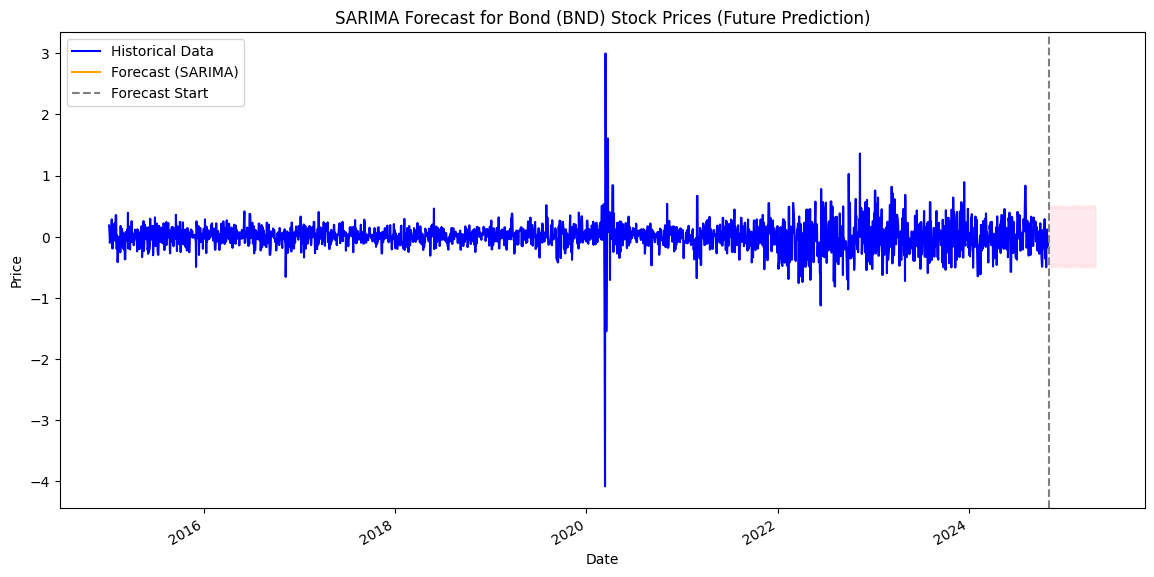

Forecast Summary:
Expected trend over the forecast duration: upward
Confidence intervals show the range of possible price fluctuations.

Volatility and Risk Analysis:
The forecast includes confidence intervals indicating expected price fluctuation ranges.

Market Opportunities and Risks:
Potential market opportunity due to an expected price increase.


c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 0.0411
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0011
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0012
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0013
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0011
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0012
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0013
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0016
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0014
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/

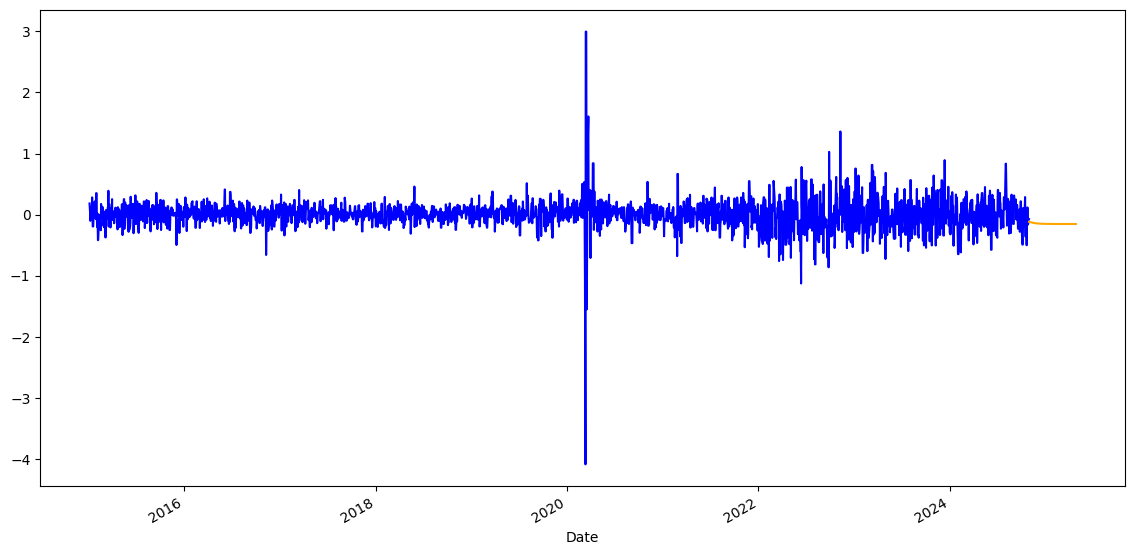

In [24]:
arima_bnd = forecast_and_evaluate(train_data_bnd, model_choice="arima", asset_label="Bond (BND)")
sarima_bnd = forecast_and_evaluate(train_data_bnd, model_choice="sarima", asset_label="Bond (BND)")
lstm_bnd = forecast_and_evaluate(train_data_bnd, model_choice="lstm", asset_label="Bond (BND)")

c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction resul

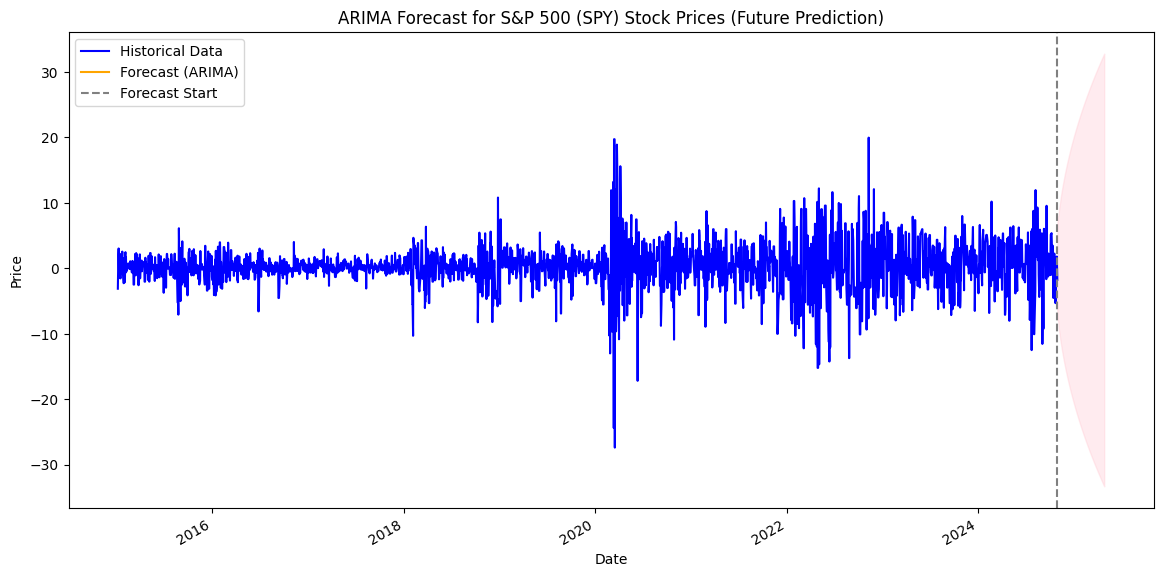

Forecast Summary:
Expected trend over the forecast duration: upward
Confidence intervals show the range of possible price fluctuations.

Volatility and Risk Analysis:
The forecast includes confidence intervals indicating expected price fluctuation ranges.

Market Opportunities and Risks:
Potential market opportunity due to an expected price increase.


c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling th

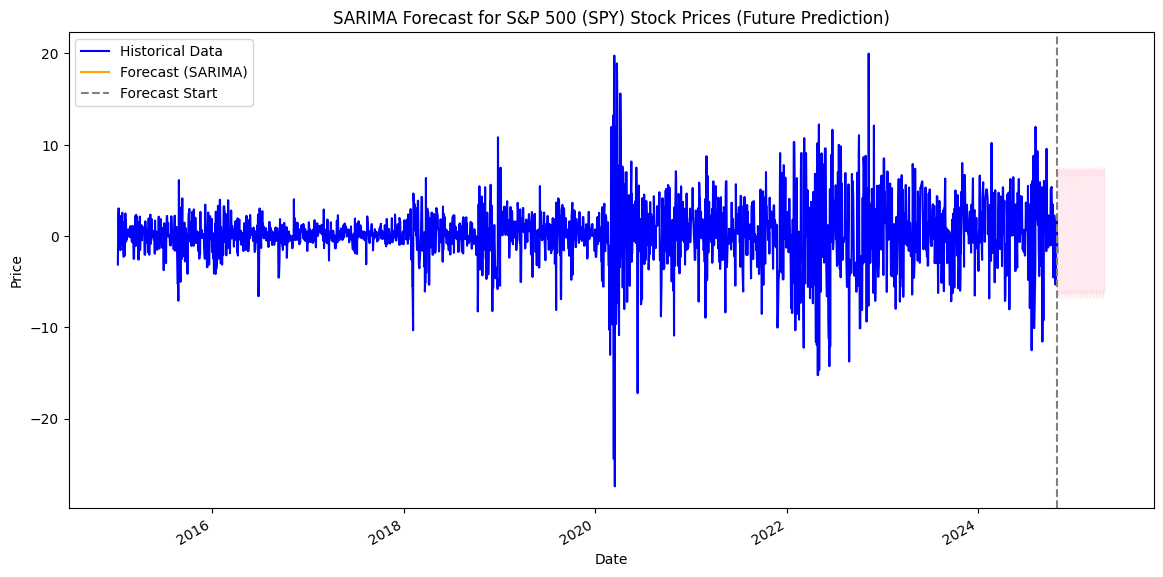

Forecast Summary:
Expected trend over the forecast duration: upward
Confidence intervals show the range of possible price fluctuations.

Volatility and Risk Analysis:
The forecast includes confidence intervals indicating expected price fluctuation ranges.

Market Opportunities and Risks:
Potential market opportunity due to an expected price increase.
Epoch 1/10


c:\Users\Abdulaziz\Desktop\10 Academy\GMF\week11\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0544
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0054
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0054
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0062
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.0053
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.0059
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0056
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0055
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0052
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0054
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━

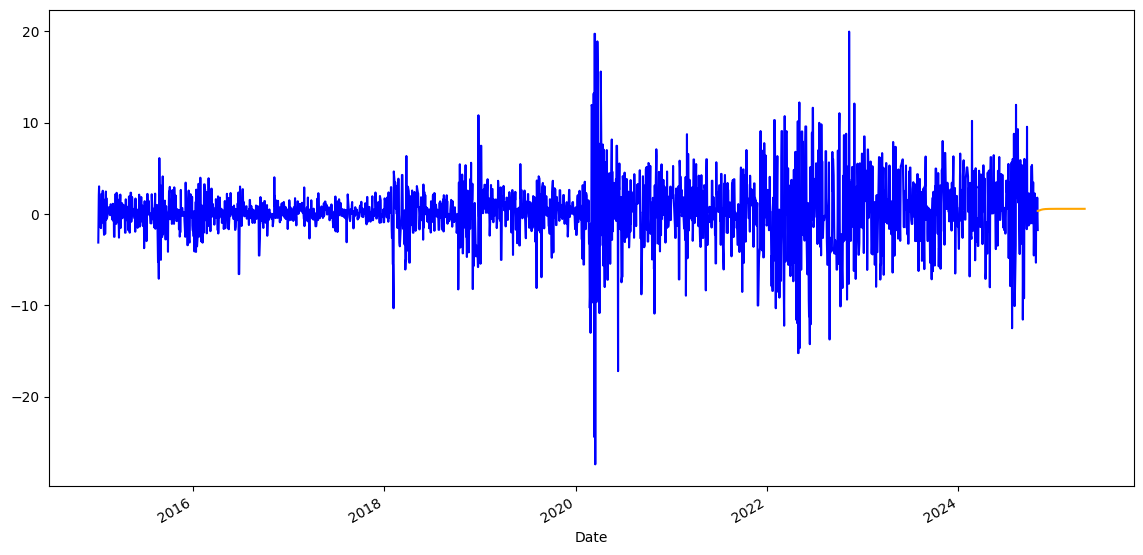

In [25]:
arima_spy = forecast_and_evaluate(train_data_spy, model_choice="arima", asset_label="S&P 500 (SPY)")
sarima_spy = forecast_and_evaluate(train_data_spy, model_choice="sarima", asset_label="S&P 500 (SPY)")
lstm_spy = forecast_and_evaluate(train_data_spy, model_choice="lstm", asset_label="S&P 500 (SPY)")

In [27]:
def extract_forecast(forecast_result, model_name, asset_name, forecast_period=180):
    if forecast_result is not None:
        print(f"{model_name} Forecast for {asset_name} completed.")
        return forecast_result['forecast']
    else:
        print(f"{model_name} Forecast for {asset_name} could not be generated.")
        return pd.Series([None] * forecast_period, index=pd.date_range(start=train_data.index[-1], periods=forecast_period, freq='D'))

In [28]:
tsla_forecasted_prices = extract_forecast(lstm_tsla, "LSTM", "TSLA")
bnd_forecasted_prices = extract_forecast(lstm_bnd, "LSTM", "BND")
spy_forecasted_prices = extract_forecast(lstm_spy, "LSTM", "SPY")

LSTM Forecast for TSLA could not be generated.
LSTM Forecast for BND could not be generated.
LSTM Forecast for SPY could not be generated.


In [29]:
forecast_df = pd.DataFrame({
    'TSLA': tsla_forecasted_prices,
    'BND': bnd_forecasted_prices,
    'SPY': spy_forecasted_prices
})

In [30]:
forecast_df = forecast_df.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')

In [31]:
forecast_df.head()

""
2024-10-30 00:00:00+00:00
2024-10-31 00:00:00+00:00
2024-11-01 00:00:00+00:00
2024-11-02 00:00:00+00:00
2024-11-03 00:00:00+00:00


In [32]:
if not forecast_df.empty:
    plt.figure(figsize=(10, 6))
    forecast_df.plot()
    plt.title('Forecasted Prices for TSLA, BND, SPY')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc="upper left")
    plt.show()
else:
    print("There is no forecast data to visualize.")

There is no forecast data to visualize.


In [33]:
daily_returns = forecast_df.pct_change().dropna()

In [34]:
annual_returns = daily_returns.mean() * 252

In [35]:
cov_matrix = daily_returns.cov() * 252

In [36]:
initial_weights = np.array([1/3, 1/3, 1/3])

In [37]:
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

In [38]:
bounds = tuple((0, 1) for _ in range(len(initial_weights)))

In [40]:
def portfolio_performance(weights, returns, cov_matrix):
    port_return = np.dot(weights, returns)  # Expected portfolio return
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Portfolio risk
    sharpe_ratio = port_return / port_volatility  # Sharpe Ratio
    return port_return, port_volatility, sharpe_ratio

def neg_sharpe_ratio(weights, returns, cov_matrix):
    return -portfolio_performance(weights, returns, cov_matrix)[2]

In [41]:
optimal_results = minimize(neg_sharpe_ratio, initial_weights, args=(annual_returns, cov_matrix),
                            method='SLSQP', bounds=bounds, constraints=constraints)


NameError: name 'minimize' is not defined

In [42]:
optimal_weights = optimal_results.x
opt_return, opt_volatility, opt_sharpe = portfolio_performance(optimal_weights, annual_returns, cov_matrix)

NameError: name 'optimal_results' is not defined

In [ ]:
confidence_level = 0.95
var_tsla = np.percentile(daily_returns['TSLA'], (1 - confidence_level) * 100)

In [ ]:
print("Optimal Weights:", optimal_weights)
print("Expected Portfolio:", opt_return)
print("Risk:", opt_volatility)
print("Ratio:", opt_sharpe)
print("95% Value at Risk for Tesla:", var_tsla)

In [ ]:
forecast_cumulative_returns = (daily_returns + 1).cumprod()
forecast_cumulative_returns['Portfolio'] = (daily_returns @ optimal_weights + 1).cumprod()

plt.figure(figsize=(12, 8))
forecast_cumulative_returns.plot()
plt.title('Cumulative Returns of Forecasted Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(['TSLA', 'BND', 'SPY', 'Optimized Portfolio'])
plt.show()

In [ ]:
print("Summary of Portfolio Optimization:")
print(" - Expected Annual Return:", opt_return)
print(" - Portfolio Volatility:", opt_volatility)
print(" - Sharpe Ratio:", opt_sharpe)
print(" - Optimal Allocation:", dict(zip(forecast_df.columns, optimal_weights)))
print(" - Value at Risk (95% Confidence) for TSLA:", var_tsla)